In [1]:
import pandas as pd
import numpy as np
import janitor as jntr
import difflib

characteristic_data = pd.read_csv("hego_data/hego_17_18_salary_by_characteristic.csv", skiprows = 13).clean_names()
institution_data = pd.read_csv("hego_data/hego_17_18_salary_by_institution.csv", skiprows = 13).clean_names()
subject_data = pd.read_csv("hego_data/hego_17_18_salary_by_subject.csv", skiprows = 13).clean_names()
uni_codes = pd.read_excel("hego_data/institution-and-campus-codes-2018-entry.xls").clean_names()
rankings_data = pd.read_csv("hego_data/Complete_University_Guide_University_League_Table.csv", skiprows=4).clean_names()

In [2]:
pd.set_option('display.max_rows', 500)

To begin with and to make sure everything is working, only one year will be used. All the other data that has been read in refers only to this year (17/18 that is) so only the ranking dataset needs filtered.

In [3]:
rankings_2017 = rankings_data.loc[rankings_data["year"] == 2017].copy()

I've been having problems with these datasets whilst trying to join them on the instituion/provider names. I've tried to do this by using what's known as fuzzy merging. This has worked to a degree, but has thrown up some significant issues. I'm now going to try and create a more concise merging process so that I can see if the merging and then correcting I've used has worked.

In [4]:
institution_data_for_merge = institution_data.copy()

In [5]:
just_2017_rankings = rankings_2017.loc[:,["rank", "institution"]].copy()

Now to define our fuzzy merge function using the following source: 

https://stackoverflow.com/questions/13636848/is-it-possible-to-do-fuzzy-match-merge-with-python-pandas/60908516#60908516

In [6]:
def fuzzy_merge(df1, df2, left_on, right_on, how='inner', cutoff=0.6):
    df_other= df2.copy()
    df_other[left_on] = [get_closest_match(x, df1[left_on], cutoff) 
                         for x in df_other[right_on]]
    return df1.merge(df_other, on=left_on, how=how)

def get_closest_match(x, other, cutoff):
    matches = difflib.get_close_matches(x, other, cutoff=cutoff)
    return matches[0] if matches else None

Through trial and error, I've worked out that the function was getting a little confused when it came to certain titles, especially "The University of....". With this in mind, I altered the provider names before the merge.

In [7]:
institution_data_for_merge["provider_name"] = institution_data_for_merge["provider_name"].str.replace("University", '')

Now time for the merge. This will require further modification and for this reason is being labelled provisional:

In [8]:
provisional_merge = fuzzy_merge(institution_data_for_merge, just_2017_rankings, left_on='provider_name', right_on='institution').copy()

So just like last time, there's a certain amount of institutions that have been misclassified and need to be hard-coded out and in:

In [9]:
provisional_merge = provisional_merge[~provisional_merge['provider_name'].isin(['College London', 'of Cumbria', 'Arden', 'Bath Spa', 'Birmingham City', 'Liverpool Hope', 'London School of Theology', 'Southport College'])]

In [10]:
second_institution_merge_data = institution_data.copy()

In [11]:
second_institution_merge_data['provider_name'] = second_institution_merge_data['provider_name'].replace({'Imperial College of Science, Technology and Medicine': 'Imperial College London'})

In [12]:
second_institution_merge_data = second_institution_merge_data[second_institution_merge_data["provider_name"].isin(['Imperial College London', 'University College London', 'University of Northumbria at Newcastle', 'University of Cumbria', 'Arden University', 'The University of Aberdeen', 'The University of Bath', 'Bath Spa University', 'The University of Liverpool', 'Liverpool Hope University', 'London School of Economics and Political Science', 'The University of Southampton', 'Solent University', 'The University of Birmingham', 'The University of York', 'The University of Kent', 'Royal Holloway and Bedford New College', 'The University of Essex', 'Goldsmiths College', 'The University of Hull', 'University of St Mark and St John'])]


In [13]:
conditions = [
    (second_institution_merge_data['provider_name'] == "Imperial College London"),
    (second_institution_merge_data['provider_name'] == "University College London"),
    (second_institution_merge_data['provider_name'] == "University of Northumbria at Newcastle"),
    (second_institution_merge_data['provider_name'] == "University of Cumbria"),
    (second_institution_merge_data['provider_name'] == "Arden University"),
    (second_institution_merge_data['provider_name'] == "The University of Aberdeen"),
    (second_institution_merge_data['provider_name'] == "The University of Bath"),
    (second_institution_merge_data['provider_name'] == "Bath Spa University"),
    (second_institution_merge_data['provider_name'] == "The University of Liverpool"),
    (second_institution_merge_data['provider_name'] == "Liverpool Hope University"),
    (second_institution_merge_data['provider_name'] == "London School of Economics and Political Science"),
    (second_institution_merge_data['provider_name'] == "The University of Southampton"),
    (second_institution_merge_data['provider_name'] == "Solent University"),
    (second_institution_merge_data['provider_name'] == "The University of Birmingham"),
    (second_institution_merge_data['provider_name'] == "The University of York"),
    (second_institution_merge_data['provider_name'] == "The University of Kent"),
    (second_institution_merge_data['provider_name'] == "Royal Holloway and Bedford New College"),
    (second_institution_merge_data['provider_name'] == "The University of Essex"),
    (second_institution_merge_data['provider_name'] == "Goldsmiths College"),
    (second_institution_merge_data['provider_name'] == "The University of Hull"),
    (second_institution_merge_data['provider_name'] == "University of St Mark and St John")
]

values = [4, 10, 59, 121,"NA",42,11,76,38,83,3,17,115,15, 20, 23, 37, 41, 51, 68, 124]

second_institution_merge_data['rank'] = np.select(conditions, values)

In [14]:
second_institution_merge_data["institution"] = second_institution_merge_data["provider_name"]

In [15]:
all_institutions_out_n_ranks_2017 = pd.concat([provisional_merge, second_institution_merge_data])

That should be the main body done, although there's still a few little extra mistakes to correct inside there.

In [16]:
all_inst_minus_mistakes = all_institutions_out_n_ranks_2017.loc[~((all_institutions_out_n_ranks_2017["provider_name"] == " College London") & (all_institutions_out_n_ranks_2017["institution"] == "Imperial College London")),:]
all_inst_minus_mistakes = all_inst_minus_mistakes.loc[~((all_inst_minus_mistakes["provider_name"] == "Arden ") & (all_inst_minus_mistakes["institution"] == "Aberdeen")),:]
all_inst_minus_mistakes = all_inst_minus_mistakes.loc[~((all_inst_minus_mistakes["provider_name"] == "Arden University") & (all_inst_minus_mistakes["institution"] == "Arden University")),:]
all_inst_minus_mistakes = all_inst_minus_mistakes.loc[~((all_inst_minus_mistakes["provider_name"] == "Bath Spa ") & (all_inst_minus_mistakes["institution"] == "Bath")),:]
all_inst_minus_mistakes = all_inst_minus_mistakes.loc[~((all_inst_minus_mistakes["provider_name"] == "Birmingham City ") & (all_inst_minus_mistakes["institution"] == "Birmingham")),:]
all_inst_minus_mistakes = all_inst_minus_mistakes.loc[~((all_inst_minus_mistakes["provider_name"] == "Liverpool Hope ") & (all_inst_minus_mistakes["institution"] == "Liverpool")),:]
                                                                   

In [17]:
all_institutions_out_n_ranks_2017 = all_inst_minus_mistakes.copy()

In [18]:
all_institutions_out_n_ranks_2017["rank"] = pd.to_numeric(all_institutions_out_n_ranks_2017["rank"])

In [19]:
all_institutions_out_n_ranks_2017 = all_institutions_out_n_ranks_2017.loc[~(all_institutions_out_n_ranks_2017["institution"].isin(["Southampton", "Northumbria", "Bath Spa", "Liverpool Hope", "Cumbria"]))]

Cool, so that looks like the main institution and ranking merge is finally done. Now to get the uni codes done. 

In [20]:
uni_codes_for_merge = uni_codes.clean_names().copy()

In [21]:
uni_codes_for_merge = uni_codes_for_merge.loc[:,["name_abbreviation", "official_name", "name"]].copy()

In [22]:
uni_codes_for_merge = uni_codes_for_merge.drop_duplicates()

In [23]:
allinst_copy_for_code_merge = all_institutions_out_n_ranks_2017.copy()

Now to try the second merge, with the codes:

In [24]:
code_merge_test = fuzzy_merge(allinst_copy_for_code_merge, uni_codes_for_merge, left_on = "institution", right_on = 'name').copy()

In [25]:
code_merge_test

,ukprn,provider_name,country_of_provider,mode_of_former_study,skill_group,work_population_marker,salary_band,number,rank,institution,name_abbreviation,official_name,name
0,10000291.0,Anglia Ruskin,England,Full-time,High skilled,Paid employment is an activity,"Less than £15,000",5,110,Anglia Ruskin,ARU,Anglia Ruskin University,Anglia Ruskin University
1,10000291.0,Anglia Ruskin,England,Full-time,High skilled,Paid employment is an activity,"£15,000 - £17,999",40,110,Anglia Ruskin,ARU,Anglia Ruskin University,Anglia Ruskin University
2,10000291.0,Anglia Ruskin,England,Full-time,High skilled,Paid employment is an activity,"£18,000 - £20,999",80,110,Anglia Ruskin,ARU,Anglia Ruskin University,Anglia Ruskin University
3,10000291.0,Anglia Ruskin,England,Full-time,High skilled,Paid employment is an activity,"£21,000 - £23,999",140,110,Anglia Ruskin,ARU,Anglia Ruskin University,Anglia Ruskin University
4,10000291.0,Anglia Ruskin,England,Full-time,High skilled,Paid employment is an activity,"£24,000 - £26,999",265,110,Anglia Ruskin,ARU,Anglia Ruskin University,Anglia Ruskin University
...,...,...,...,...,...,...,...,...,...,...,...,...,...
85295,10007167.0,The University of York,England,Part-time,All,Paid employment is most important activity,"£39,000+",5,20,The University of York,SALF,The University of Salford,The University of Salford
85296,10007167.0,The University of York,England,Part-time,All,Paid employment is most important activity,"£39,000+",5,20,The University of York,UCS,University of Suffolk,University of Suffolk
85297,10007167.0,The University of York,England,Part-time,All,Paid employment is most important activity,"£39,000+",5,20,The University of York,WARW,The University of Warwick,The University of Warwick
85298,10007167.0,The University of York,England,Part-time,All,Paid employment is most important activity,"£39,000+",5,20,The University of York,WORCS,University of Worcester,University of Worcester


In [26]:
code_merge_groups = code_merge_test.groupby(['institution', 'name_abbreviation']).size().reset_index().rename(columns={0:'count'})

In [27]:
code_merge_groups

,institution,name_abbreviation,count
0,Anglia Ruskin,ARU,480
1,Arts University Bournemouth,AUCB,400
2,Arts University Bournemouth,PORT,400
3,Bath Spa University,BANGR,400
4,Bath Spa University,BASPA,400
5,Bath Spa University,BPP,400
6,Bath Spa University,CARDF,400
7,Bath Spa University,DUR,400
8,Bath Spa University,FAL,400
9,Bath Spa University,LANCR,400


Ok, so this is where we ran into problems on the first atttempt, although one of the big mistakes before was using one of the original datasets rather than our edited version (institution_outcomes_rankings_2017 vs all_institutions_out_n_ranks_2017). Time to have another go:

In [28]:
minus_college_codes_for_merge = uni_codes_for_merge.replace({'name': {'UCL (University College London': 'UCL', 'Imperial College London': 'ICL', "King's College London (University of London)": 'KCL'}})

In [29]:
minus_college_codes_for_merge_final = minus_college_codes_for_merge.loc[~minus_college_codes_for_merge["name"].str.contains("College", case = False)].copy()

In [30]:
minus_college_codes_for_merge_final = minus_college_codes_for_merge_final.replace({'name': {'UCL':'UCL (University College London' , 'ICL': 'Imperial College London' ,'KCL': "King's College London (University of London)"}})


In [31]:
second_code_merge_test = fuzzy_merge(minus_college_codes_for_merge_final, allinst_copy_for_code_merge, left_on = 'name', right_on = "institution", cutoff=0.4).copy()

In [32]:
second_code_merge_groups = second_code_merge_test.groupby(['institution', 'provider_name', 'name', 'name_abbreviation', 'rank']).size().reset_index().rename(columns={0:'count'})

In [33]:
second_code_merge_groups

,institution,provider_name,name,name_abbreviation,rank,count
0,Abertay,Abertay,Abertay University,ABTAY,86,440
1,Aberystwyth,Aberystwyth,Aberystwyth University,ABWTH,87,440
2,Anglia Ruskin,Anglia Ruskin,Anglia Ruskin University,ARU,110,480
3,Arts University Bournemouth,The Arts Bournemouth,Arts University Bournemouth,AUCB,76,400
4,Aston,Aston,Access to Music,ACCM,30,480
5,Bangor,Bangor,Bangor University,BANGR,62,440
6,Bath Spa University,Bath Spa University,Bath Spa University,BASPA,76,400
7,Bedfordshire,of Bedfordshire,University of Bedfordshire,BEDS,120,480
8,Birmingham City,Birmingham City,Birmingham City University,BCITY,95,440
9,Bishop Grosseteste,Bishop Grosseteste,Bishop Grosseteste University,BGU,119,320


In [34]:
second_code_merge_groups.sort_values("rank", ascending = True)

,institution,provider_name,name,name_abbreviation,rank,count
18,Cambridge,The of Cambridge,University of Cambridge,CAM,1,320
71,Oxford,The of Oxford,Oxford University,OXF,2,400
60,London School of Economics and Political Science,London School of Economics and Political Science,London School of Economics and Political Scien...,LSE,3,320
47,Imperial College London,Imperial College London,Imperial College London,IMP,4,320
89,St Andrews,The of St Andrews,University of St Andrews,STA,5,440
30,Durham,of Durham,Durham University,DUR,6,400
62,Loughborough,Loughborough,Loughborough University,LBRO,7,440
118,Warwick,The of Warwick,The University of Warwick,WARW,8,440
51,Lancaster,The of Lancaster,Lancaster University,LANCR,9,320
110,University College London,College London,SOAS University of London,SOAS,10,400


In [35]:
institution_group_ordered = all_institutions_out_n_ranks_2017.groupby(['institution', 'provider_name', 'rank']).size().reset_index().rename(columns={0:'count'}).copy()

In [36]:
institution_group_ordered.sort_values("rank", ascending = True)

,institution,provider_name,rank,count
18,Cambridge,The of Cambridge,1,320
72,Oxford,The of Oxford,2,400
60,London School of Economics and Political Science,London School of Economics and Political Science,3,320
47,Imperial College London,Imperial College London,4,320
90,St Andrews,The of St Andrews,5,440
30,Durham,of Durham,6,400
62,Loughborough,Loughborough,7,440
119,Warwick,The of Warwick,8,440
51,Lancaster,The of Lancaster,9,320
111,University College London,College London,10,400


In [37]:
second_code_merge_groups = second_code_merge_test.groupby(['institution', 'provider_name', 'name', 'name_abbreviation', 'rank']).size().reset_index().rename(columns={0:'count'})

In [38]:
all_institutions_out_n_ranks_2017.describe(include = "all")

,ukprn,provider_name,country_of_provider,mode_of_former_study,skill_group,work_population_marker,salary_band,number,rank,institution
count,5.574000e+04,55740,55740,55740,55740,55740,55740,55740.000000,55740.000000,55740
unique,NaN,128,5,3,4,2,10,NaN,NaN,127
top,NaN,The of Lincoln,All,Full-time,All,Paid employment is an activity,"£18,000 - £20,999",NaN,NaN,University College London
freq,NaN,480,27870,20480,14720,27900,5574,NaN,NaN,800
mean,1.000675e+07,NaN,NaN,NaN,NaN,NaN,NaN,26.819699,65.428776,NaN
std,4.547923e+03,NaN,NaN,NaN,NaN,NaN,NaN,52.790819,36.424347,NaN
min,1.000029e+07,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,NaN
25%,1.000534e+07,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,34.000000,NaN
50%,1.000716e+07,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,67.000000,NaN
75%,1.000779e+07,NaN,NaN,NaN,NaN,NaN,NaN,25.000000,97.000000,NaN


In [39]:
min_prov_all_institutions_out_n_ranks_2017 = all_institutions_out_n_ranks_2017.drop('provider_name', 1).copy()

In [40]:
min_prov_all_institutions_out_n_ranks_2017 = min_prov_all_institutions_out_n_ranks_2017.drop_duplicates(keep = 'first')

In [41]:
extra_institution_group_ordered = min_prov_all_institutions_out_n_ranks_2017.groupby(['institution', 'rank']).size().reset_index().rename(columns={0:'count'}).copy()

In [42]:
extra_institution_group_ordered

,institution,rank,count
0,Abertay,86,440
1,Aberystwyth,87,440
2,Anglia Ruskin,110,480
3,Arts University Bournemouth,76,400
4,Aston,30,480
5,Bangor,62,440
6,Bath Spa University,76,400
7,Bedfordshire,120,480
8,Birmingham City,95,440
9,Bishop Grosseteste,119,320


In [43]:
min_prov_all_institutions_out_n_ranks_2017.duplicated().any() 

False

In [44]:
institution_data

,ukprn,provider_name,country_of_provider,mode_of_former_study,skill_group,work_population_marker,salary_band,number
0,10008071.0,AA School of Architecture,England,Full-time,High skilled,Paid employment is an activity,"Less than £15,000",0
1,10008071.0,AA School of Architecture,England,Full-time,High skilled,Paid employment is an activity,"£15,000 - £17,999",0
2,10008071.0,AA School of Architecture,England,Full-time,High skilled,Paid employment is an activity,"£18,000 - £20,999",0
3,10008071.0,AA School of Architecture,England,Full-time,High skilled,Paid employment is an activity,"£21,000 - £23,999",0
4,10008071.0,AA School of Architecture,England,Full-time,High skilled,Paid employment is an activity,"£24,000 - £26,999",0
...,...,...,...,...,...,...,...,...
113875,NaN,Total,Wales,Part-time,Medium skilled,Paid employment is most important activity,"£27,000 - £29,999",0
113876,NaN,Total,Wales,Part-time,Medium skilled,Paid employment is most important activity,"£30,000 - £32,999",5
113877,NaN,Total,Wales,Part-time,Medium skilled,Paid employment is most important activity,"£33,000 - £35,999",10
113878,NaN,Total,Wales,Part-time,Medium skilled,Paid employment is most important activity,"£36,000 - £38,999",5


In [45]:
leeds_check = institution_data.loc[institution_data["ukprn"] == 10003854.0].copy()

In [46]:
leeds_check

,ukprn,provider_name,country_of_provider,mode_of_former_study,skill_group,work_population_marker,salary_band,number
52460,10003854.0,Leeds Arts University,England,Full-time,High skilled,Paid employment is an activity,"Less than £15,000",5
52461,10003854.0,Leeds Arts University,England,Full-time,High skilled,Paid employment is an activity,"£15,000 - £17,999",5
52462,10003854.0,Leeds Arts University,England,Full-time,High skilled,Paid employment is an activity,"£18,000 - £20,999",25
52463,10003854.0,Leeds Arts University,England,Full-time,High skilled,Paid employment is an activity,"£21,000 - £23,999",15
52464,10003854.0,Leeds Arts University,England,Full-time,High skilled,Paid employment is an activity,"£24,000 - £26,999",10
52465,10003854.0,Leeds Arts University,England,Full-time,High skilled,Paid employment is an activity,"£27,000 - £29,999",0
52466,10003854.0,Leeds Arts University,England,Full-time,High skilled,Paid employment is an activity,"£30,000 - £32,999",0
52467,10003854.0,Leeds Arts University,England,Full-time,High skilled,Paid employment is an activity,"£33,000 - £35,999",0
52468,10003854.0,Leeds Arts University,England,Full-time,High skilled,Paid employment is an activity,"£36,000 - £38,999",0
52469,10003854.0,Leeds Arts University,England,Full-time,High skilled,Paid employment is an activity,"£39,000+",0


In [47]:
min_prov_all_institutions_out_n_ranks_2017.loc[min_prov_all_institutions_out_n_ranks_2017["institution"] == "Leeds"]

,ukprn,country_of_provider,mode_of_former_study,skill_group,work_population_marker,salary_band,number,rank,institution
25540,10003854.0,England,Full-time,High skilled,Paid employment is an activity,"Less than £15,000",5,16,Leeds
25541,10003854.0,England,Full-time,High skilled,Paid employment is an activity,"£15,000 - £17,999",5,16,Leeds
25542,10003854.0,England,Full-time,High skilled,Paid employment is an activity,"£18,000 - £20,999",25,16,Leeds
25543,10003854.0,England,Full-time,High skilled,Paid employment is an activity,"£21,000 - £23,999",15,16,Leeds
25544,10003854.0,England,Full-time,High skilled,Paid employment is an activity,"£24,000 - £26,999",10,16,Leeds
25545,10003854.0,England,Full-time,High skilled,Paid employment is an activity,"£27,000 - £29,999",0,16,Leeds
25546,10003854.0,England,Full-time,High skilled,Paid employment is an activity,"£30,000 - £32,999",0,16,Leeds
25547,10003854.0,England,Full-time,High skilled,Paid employment is an activity,"£33,000 - £35,999",0,16,Leeds
25548,10003854.0,England,Full-time,High skilled,Paid employment is an activity,"£36,000 - £38,999",0,16,Leeds
25549,10003854.0,England,Full-time,High skilled,Paid employment is an activity,"£39,000+",0,16,Leeds


Looks like the Leeds Data is wrong so we'll need to take this out and put a replacement back in. Then we can finalize the removal of the UCL duplicates and then finally get around to making the final code adjustments.

In [48]:
minus_leeds = all_institutions_out_n_ranks_2017.loc[~(all_institutions_out_n_ranks_2017['institution'] == "Leeds")].copy()

In [49]:
minus_leeds.columns

Index(['ukprn', 'provider_name', 'country_of_provider', 'mode_of_former_study',
       'skill_group', 'work_population_marker', 'salary_band', 'number',
       'rank', 'institution'],
      dtype='object')

In [50]:
institution_data.columns

Index(['ukprn', 'provider_name', 'country_of_provider', 'mode_of_former_study',
       'skill_group', 'work_population_marker', 'salary_band', 'number'],
      dtype='object')

In [51]:
just_leeds_no_ranks = institution_data.loc[institution_data['provider_name'] == "The University of Leeds"].copy() 

In [52]:
just_leeds_no_ranks

,ukprn,provider_name,country_of_provider,mode_of_former_study,skill_group,work_population_marker,salary_band,number
53700,10007795.0,The University of Leeds,England,Full-time,High skilled,Paid employment is an activity,"Less than £15,000",5
53701,10007795.0,The University of Leeds,England,Full-time,High skilled,Paid employment is an activity,"£15,000 - £17,999",40
53702,10007795.0,The University of Leeds,England,Full-time,High skilled,Paid employment is an activity,"£18,000 - £20,999",180
53703,10007795.0,The University of Leeds,England,Full-time,High skilled,Paid employment is an activity,"£21,000 - £23,999",240
53704,10007795.0,The University of Leeds,England,Full-time,High skilled,Paid employment is an activity,"£24,000 - £26,999",310
53705,10007795.0,The University of Leeds,England,Full-time,High skilled,Paid employment is an activity,"£27,000 - £29,999",220
53706,10007795.0,The University of Leeds,England,Full-time,High skilled,Paid employment is an activity,"£30,000 - £32,999",200
53707,10007795.0,The University of Leeds,England,Full-time,High skilled,Paid employment is an activity,"£33,000 - £35,999",70
53708,10007795.0,The University of Leeds,England,Full-time,High skilled,Paid employment is an activity,"£36,000 - £38,999",40
53709,10007795.0,The University of Leeds,England,Full-time,High skilled,Paid employment is an activity,"£39,000+",70


In [53]:
just_leeds_no_ranks['rank'] = 16

just_leeds_no_ranks['institution'] = 'Leeds'

just_leeds_no_ranks

,ukprn,provider_name,country_of_provider,mode_of_former_study,skill_group,work_population_marker,salary_band,number,rank,institution
53700,10007795.0,The University of Leeds,England,Full-time,High skilled,Paid employment is an activity,"Less than £15,000",5,16,Leeds
53701,10007795.0,The University of Leeds,England,Full-time,High skilled,Paid employment is an activity,"£15,000 - £17,999",40,16,Leeds
53702,10007795.0,The University of Leeds,England,Full-time,High skilled,Paid employment is an activity,"£18,000 - £20,999",180,16,Leeds
53703,10007795.0,The University of Leeds,England,Full-time,High skilled,Paid employment is an activity,"£21,000 - £23,999",240,16,Leeds
53704,10007795.0,The University of Leeds,England,Full-time,High skilled,Paid employment is an activity,"£24,000 - £26,999",310,16,Leeds
53705,10007795.0,The University of Leeds,England,Full-time,High skilled,Paid employment is an activity,"£27,000 - £29,999",220,16,Leeds
53706,10007795.0,The University of Leeds,England,Full-time,High skilled,Paid employment is an activity,"£30,000 - £32,999",200,16,Leeds
53707,10007795.0,The University of Leeds,England,Full-time,High skilled,Paid employment is an activity,"£33,000 - £35,999",70,16,Leeds
53708,10007795.0,The University of Leeds,England,Full-time,High skilled,Paid employment is an activity,"£36,000 - £38,999",40,16,Leeds
53709,10007795.0,The University of Leeds,England,Full-time,High skilled,Paid employment is an activity,"£39,000+",70,16,Leeds


In [54]:
all_institutions_out_n_ranks_2017 = pd.concat([minus_leeds, just_leeds_no_ranks])

In [55]:
all_institutions_out_n_ranks_2017.loc[all_institutions_out_n_ranks_2017["institution"] == "Leeds"].count()

ukprn                     440
provider_name             440
country_of_provider       440
mode_of_former_study      440
skill_group               440
work_population_marker    440
salary_band               440
number                    440
rank                      440
institution               440
dtype: int64

That should be the Leeds problems sorted.

In [56]:
institution_group_ordered = all_institutions_out_n_ranks_2017.groupby(['institution', 'provider_name', 'rank']).size().reset_index().rename(columns={0:'count'}).copy()

institution_group_ordered.sort_values("rank", ascending = True)

,institution,provider_name,rank,count
18,Cambridge,The of Cambridge,1,320
72,Oxford,The of Oxford,2,400
60,London School of Economics and Political Science,London School of Economics and Political Science,3,320
47,Imperial College London,Imperial College London,4,320
90,St Andrews,The of St Andrews,5,440
30,Durham,of Durham,6,400
62,Loughborough,Loughborough,7,440
119,Warwick,The of Warwick,8,440
51,Lancaster,The of Lancaster,9,320
111,University College London,College London,10,400


In [57]:
all_institutions_out_n_ranks_2017 = all_institutions_out_n_ranks_2017.drop_duplicates(subset = all_institutions_out_n_ranks_2017.columns.difference(['provider_name']), keep= "first")

In [58]:
institution_group_ordered = all_institutions_out_n_ranks_2017.groupby(['institution', 'provider_name', 'rank']).size().reset_index().rename(columns={0:'count'}).copy()

institution_group_ordered.sort_values("rank", ascending = True)

,institution,provider_name,rank,count
18,Cambridge,The of Cambridge,1,320
72,Oxford,The of Oxford,2,400
60,London School of Economics and Political Science,London School of Economics and Political Science,3,320
47,Imperial College London,Imperial College London,4,320
90,St Andrews,The of St Andrews,5,440
30,Durham,of Durham,6,400
62,Loughborough,Loughborough,7,440
118,Warwick,The of Warwick,8,440
51,Lancaster,The of Lancaster,9,320
111,University College London,College London,10,400


Looks like the UCL duplicates have been easily removed and now I have a finalised clean data set, at least before the third attempt at a code merge. 

In [59]:
minus_college_codes_for_merge_final.count()

name_abbreviation    192
official_name        192
name                 192
dtype: int64

In [60]:
all_institutions_out_n_ranks_2017

,ukprn,provider_name,country_of_provider,mode_of_former_study,skill_group,work_population_marker,salary_band,number,rank,institution
0,10007849.0,Abertay,Scotland,Full-time,High skilled,Paid employment is an activity,"Less than £15,000",0,86,Abertay
1,10007849.0,Abertay,Scotland,Full-time,High skilled,Paid employment is an activity,"£15,000 - £17,999",5,86,Abertay
2,10007849.0,Abertay,Scotland,Full-time,High skilled,Paid employment is an activity,"£18,000 - £20,999",20,86,Abertay
3,10007849.0,Abertay,Scotland,Full-time,High skilled,Paid employment is an activity,"£21,000 - £23,999",20,86,Abertay
4,10007849.0,Abertay,Scotland,Full-time,High skilled,Paid employment is an activity,"£24,000 - £26,999",35,86,Abertay
...,...,...,...,...,...,...,...,...,...,...
54135,10007795.0,The University of Leeds,England,Part-time,All,Paid employment is most important activity,"£27,000 - £29,999",0,16,Leeds
54136,10007795.0,The University of Leeds,England,Part-time,All,Paid employment is most important activity,"£30,000 - £32,999",0,16,Leeds
54137,10007795.0,The University of Leeds,England,Part-time,All,Paid employment is most important activity,"£33,000 - £35,999",0,16,Leeds
54138,10007795.0,The University of Leeds,England,Part-time,All,Paid employment is most important activity,"£36,000 - £38,999",0,16,Leeds


In [61]:
third_code_merge = fuzzy_merge(minus_college_codes_for_merge_final, all_institutions_out_n_ranks_2017, left_on = 'name', right_on = "institution", cutoff=0.4).copy()



In [62]:
third_code_merge_groups = third_code_merge.groupby(['institution', 'provider_name', 'name', 'name_abbreviation', 'rank']).size().reset_index().rename(columns={0:'count'})

In [63]:
third_code_merge_groups.count()

institution          126
provider_name        126
name                 126
name_abbreviation    126
rank                 126
count                126
dtype: int64

In [64]:
third_code_merge.count()

name_abbreviation         55020
official_name             55020
name                      55020
ukprn                     55020
provider_name             55020
country_of_provider       55020
mode_of_former_study      55020
skill_group               55020
work_population_marker    55020
salary_band               55020
number                    55020
rank                      55020
institution               55020
dtype: int64

In [65]:
all_institutions_out_n_ranks_2017.count()

ukprn                     55460
provider_name             55460
country_of_provider       55460
mode_of_former_study      55460
skill_group               55460
work_population_marker    55460
salary_band               55460
number                    55460
rank                      55460
institution               55460
dtype: int64

So there are still a mistakes here between the two parts and oddly we seem to have lost 440 rows. 

Thinking that the quickest way to check the missing rows will be to combine these and then check for duplicates. 

In [66]:
third_code_merge.columns

Index(['name_abbreviation', 'official_name', 'name', 'ukprn', 'provider_name',
       'country_of_provider', 'mode_of_former_study', 'skill_group',
       'work_population_marker', 'salary_band', 'number', 'rank',
       'institution'],
      dtype='object')

In [67]:
all_institutions_out_n_ranks_2017.columns


Index(['ukprn', 'provider_name', 'country_of_provider', 'mode_of_former_study',
       'skill_group', 'work_population_marker', 'salary_band', 'number',
       'rank', 'institution'],
      dtype='object')

In [68]:
check_the_missing_concat = pd.concat([third_code_merge, all_institutions_out_n_ranks_2017]).copy()

In [69]:
check_the_missing_concat

,name_abbreviation,official_name,name,ukprn,provider_name,country_of_provider,mode_of_former_study,skill_group,work_population_marker,salary_band,number,rank,institution
0,ABRDN,The University of Aberdeen,The University of Aberdeen,10007783.0,The University of Aberdeen,Scotland,Full-time,High skilled,Paid employment is an activity,"Less than £15,000",5,42,The University of Aberdeen
1,ABRDN,The University of Aberdeen,The University of Aberdeen,10007783.0,The University of Aberdeen,Scotland,Full-time,High skilled,Paid employment is an activity,"£15,000 - £17,999",5,42,The University of Aberdeen
2,ABRDN,The University of Aberdeen,The University of Aberdeen,10007783.0,The University of Aberdeen,Scotland,Full-time,High skilled,Paid employment is an activity,"£18,000 - £20,999",40,42,The University of Aberdeen
3,ABRDN,The University of Aberdeen,The University of Aberdeen,10007783.0,The University of Aberdeen,Scotland,Full-time,High skilled,Paid employment is an activity,"£21,000 - £23,999",45,42,The University of Aberdeen
4,ABRDN,The University of Aberdeen,The University of Aberdeen,10007783.0,The University of Aberdeen,Scotland,Full-time,High skilled,Paid employment is an activity,"£24,000 - £26,999",70,42,The University of Aberdeen
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54135,NaN,NaN,NaN,10007795.0,The University of Leeds,England,Part-time,All,Paid employment is most important activity,"£27,000 - £29,999",0,16,Leeds
54136,NaN,NaN,NaN,10007795.0,The University of Leeds,England,Part-time,All,Paid employment is most important activity,"£30,000 - £32,999",0,16,Leeds
54137,NaN,NaN,NaN,10007795.0,The University of Leeds,England,Part-time,All,Paid employment is most important activity,"£33,000 - £35,999",0,16,Leeds
54138,NaN,NaN,NaN,10007795.0,The University of Leeds,England,Part-time,All,Paid employment is most important activity,"£36,000 - £38,999",0,16,Leeds


In [70]:
check_the_missing = check_the_missing_concat.drop_duplicates(subset = check_the_missing_concat.columns.difference(['name_abbreviation', 'official_name', 'name']), keep= False).copy()

In [71]:
check_the_missing

,name_abbreviation,official_name,name,ukprn,provider_name,country_of_provider,mode_of_former_study,skill_group,work_population_marker,salary_band,number,rank,institution
32480,NaN,NaN,NaN,10007832.0,Newman,England,Full-time,High skilled,Paid employment is an activity,"Less than £15,000",0,117,Newman
32481,NaN,NaN,NaN,10007832.0,Newman,England,Full-time,High skilled,Paid employment is an activity,"£15,000 - £17,999",10,117,Newman
32482,NaN,NaN,NaN,10007832.0,Newman,England,Full-time,High skilled,Paid employment is an activity,"£18,000 - £20,999",10,117,Newman
32483,NaN,NaN,NaN,10007832.0,Newman,England,Full-time,High skilled,Paid employment is an activity,"£21,000 - £23,999",30,117,Newman
32484,NaN,NaN,NaN,10007832.0,Newman,England,Full-time,High skilled,Paid employment is an activity,"£24,000 - £26,999",30,117,Newman
32485,NaN,NaN,NaN,10007832.0,Newman,England,Full-time,High skilled,Paid employment is an activity,"£27,000 - £29,999",5,117,Newman
32486,NaN,NaN,NaN,10007832.0,Newman,England,Full-time,High skilled,Paid employment is an activity,"£30,000 - £32,999",0,117,Newman
32487,NaN,NaN,NaN,10007832.0,Newman,England,Full-time,High skilled,Paid employment is an activity,"£33,000 - £35,999",0,117,Newman
32488,NaN,NaN,NaN,10007832.0,Newman,England,Full-time,High skilled,Paid employment is an activity,"£36,000 - £38,999",0,117,Newman
32489,NaN,NaN,NaN,10007832.0,Newman,England,Full-time,High skilled,Paid employment is an activity,"£39,000+",0,117,Newman


Cool, so looks like I've found them. There for the institutions Newman (117) so we should be able to just add these on and to the third merge.

In [72]:
minus_college_codes_for_merge_final

,name_abbreviation,official_name,name
1,ABRDN,The University of Aberdeen,The University of Aberdeen
2,ABTAY,University of Abertay Dundee,Abertay University
4,ABWTH,Aberystwyth University,Aberystwyth University
12,ACCM,Access to Music,Access to Music
22,ACM,The Academy of Contemporary Music,The Academy of Contemporary Music
27,AFA,Amsterdam Fashion Academy,Amsterdam Fashion Academy
28,ARU,Anglia Ruskin University,Anglia Ruskin University
44,AUCB,Arts University Bournemouth,Arts University Bournemouth
49,ASTON,Aston University,"Aston University, Birmingham"
50,BANGR,Bangor University,Bangor University


In [73]:
check_the_missing["name_abbreviation"] = check_the_missing["name_abbreviation"].fillna("NEWB")
check_the_missing["official_name"] = check_the_missing["official_name"].fillna("Newman University, Birmingham")
check_the_missing["name"] = check_the_missing["name"].fillna("Newman University, Birmingham")

In [74]:
check_the_missing

,name_abbreviation,official_name,name,ukprn,provider_name,country_of_provider,mode_of_former_study,skill_group,work_population_marker,salary_band,number,rank,institution
32480,NEWB,"Newman University, Birmingham","Newman University, Birmingham",10007832.0,Newman,England,Full-time,High skilled,Paid employment is an activity,"Less than £15,000",0,117,Newman
32481,NEWB,"Newman University, Birmingham","Newman University, Birmingham",10007832.0,Newman,England,Full-time,High skilled,Paid employment is an activity,"£15,000 - £17,999",10,117,Newman
32482,NEWB,"Newman University, Birmingham","Newman University, Birmingham",10007832.0,Newman,England,Full-time,High skilled,Paid employment is an activity,"£18,000 - £20,999",10,117,Newman
32483,NEWB,"Newman University, Birmingham","Newman University, Birmingham",10007832.0,Newman,England,Full-time,High skilled,Paid employment is an activity,"£21,000 - £23,999",30,117,Newman
32484,NEWB,"Newman University, Birmingham","Newman University, Birmingham",10007832.0,Newman,England,Full-time,High skilled,Paid employment is an activity,"£24,000 - £26,999",30,117,Newman
32485,NEWB,"Newman University, Birmingham","Newman University, Birmingham",10007832.0,Newman,England,Full-time,High skilled,Paid employment is an activity,"£27,000 - £29,999",5,117,Newman
32486,NEWB,"Newman University, Birmingham","Newman University, Birmingham",10007832.0,Newman,England,Full-time,High skilled,Paid employment is an activity,"£30,000 - £32,999",0,117,Newman
32487,NEWB,"Newman University, Birmingham","Newman University, Birmingham",10007832.0,Newman,England,Full-time,High skilled,Paid employment is an activity,"£33,000 - £35,999",0,117,Newman
32488,NEWB,"Newman University, Birmingham","Newman University, Birmingham",10007832.0,Newman,England,Full-time,High skilled,Paid employment is an activity,"£36,000 - £38,999",0,117,Newman
32489,NEWB,"Newman University, Birmingham","Newman University, Birmingham",10007832.0,Newman,England,Full-time,High skilled,Paid employment is an activity,"£39,000+",0,117,Newman


Just going to quickly check that Newman had definitely been left off the original third merge. 

In [75]:
third_code_merge.loc[third_code_merge["institution"] == "Newman"]

,name_abbreviation,official_name,name,ukprn,provider_name,country_of_provider,mode_of_former_study,skill_group,work_population_marker,salary_band,number,rank,institution


In [76]:
third_code_merge_correct = pd.concat([third_code_merge, check_the_missing]).copy()

In [77]:
third_code_merge_correct.count()

name_abbreviation         55460
official_name             55460
name                      55460
ukprn                     55460
provider_name             55460
country_of_provider       55460
mode_of_former_study      55460
skill_group               55460
work_population_marker    55460
salary_band               55460
number                    55460
rank                      55460
institution               55460
dtype: int64

Cool, so now it's time to get in there and make those corrections to the codes. I think we've got the accurate list from before of those that have been labelled incorrectly:

Mismatches:

Aston = Access to Music

East London = ARU London

Exeter = Petroc

King's College London = Imperial College London

Liverpool = Liverpool Hope University

Nottingham = Nottingham Trent University

Surrey = NESCOT, Surrey

University College London = SOAS University of London

West London = ARU London

West of England, Bristol = University of Bristol

Westminster = University of Winchester

Wrexham Glyndŵr = Durham University

In [78]:
third_code_merge_groups = third_code_merge.groupby(['institution', 'provider_name', 'name', 'name_abbreviation', 'rank']).size().reset_index().rename(columns={0:'count'})

In [79]:
third_code_merge_groups.sort_values("rank", ascending = True)

,institution,provider_name,name,name_abbreviation,rank,count
18,Cambridge,The of Cambridge,University of Cambridge,CAM,1,320
71,Oxford,The of Oxford,Oxford University,OXF,2,400
60,London School of Economics and Political Science,London School of Economics and Political Science,London School of Economics and Political Scien...,LSE,3,320
47,Imperial College London,Imperial College London,Imperial College London,IMP,4,320
89,St Andrews,The of St Andrews,University of St Andrews,STA,5,440
30,Durham,of Durham,Durham University,DUR,6,400
62,Loughborough,Loughborough,Loughborough University,LBRO,7,440
117,Warwick,The of Warwick,The University of Warwick,WARW,8,440
51,Lancaster,The of Lancaster,Lancaster University,LANCR,9,320
110,University College London,College London,SOAS University of London,SOAS,10,400


In [80]:
third_merge_minus_mistakes = third_code_merge_correct.loc[~((third_code_merge_correct["institution"] == "University College London") & (third_code_merge_correct["name"] == "SOAS University of London")),:].copy()
third_merge_minus_mistakes = third_merge_minus_mistakes.loc[~((third_merge_minus_mistakes["institution"] == "Surrey") & (third_merge_minus_mistakes["name"] == "NESCOT, Surrey" )),:]
third_merge_minus_mistakes = third_merge_minus_mistakes.loc[~((third_merge_minus_mistakes["institution"] == "Exeter") & (third_merge_minus_mistakes["name"] == "Petroc" )),:]
third_merge_minus_mistakes = third_merge_minus_mistakes.loc[~((third_merge_minus_mistakes["institution"] == "King's College London") & (third_merge_minus_mistakes["name"] == "Imperial College London" )),:]
third_merge_minus_mistakes = third_merge_minus_mistakes.loc[~((third_merge_minus_mistakes["institution"] == "Aston") & (third_merge_minus_mistakes["name"] == "Access to Music" )),:]
third_merge_minus_mistakes = third_merge_minus_mistakes.loc[~((third_merge_minus_mistakes["institution"] == "Goldsmiths College") & (third_merge_minus_mistakes["name"] == "Imperial College London" )),:]
third_merge_minus_mistakes = third_merge_minus_mistakes.loc[~((third_merge_minus_mistakes["institution"] == "University of Northumbria at Newcastle") & (third_merge_minus_mistakes["name"] == "University of Cumbria" )),:]
third_merge_minus_mistakes = third_merge_minus_mistakes.loc[~((third_merge_minus_mistakes["institution"] == "West of England, Bristol") & (third_merge_minus_mistakes["name"] == "University of Bristol" )),:]
third_merge_minus_mistakes = third_merge_minus_mistakes.loc[~((third_merge_minus_mistakes["institution"] == "Westminster") & (third_merge_minus_mistakes["name"] == "University of Winchester" )),:]
third_merge_minus_mistakes = third_merge_minus_mistakes.loc[~((third_merge_minus_mistakes["institution"] == "West London") & (third_merge_minus_mistakes["name"] == "ARU London" )),:]
third_merge_minus_mistakes = third_merge_minus_mistakes.loc[~((third_merge_minus_mistakes["institution"] == "Solent University") & (third_merge_minus_mistakes["name"] == "Coventry University" )),:]
third_merge_minus_mistakes = third_merge_minus_mistakes.loc[~((third_merge_minus_mistakes["institution"] == "University of St Mark and St John") & (third_merge_minus_mistakes["name"] == "University of the Arts London" )),:]
third_merge_minus_mistakes = third_merge_minus_mistakes.loc[~((third_merge_minus_mistakes["institution"] == "Wrexham Glyndŵr") & (third_merge_minus_mistakes["name"] == "Durham University" )),:]
third_merge_minus_mistakes = third_merge_minus_mistakes.loc[~((third_merge_minus_mistakes["institution"] == "East London") & (third_merge_minus_mistakes["name"] == "ARU London" )),:]



In [81]:
third_merge_minus_mistakes_groups = third_merge_minus_mistakes.groupby(['institution', 'provider_name', 'name', 'name_abbreviation', 'rank']).size().reset_index().rename(columns={0:'count'})

third_merge_minus_mistakes_groups.count()


institution          113
provider_name        113
name                 113
name_abbreviation    113
rank                 113
count                113
dtype: int64

In [82]:
third_merge_mistakes = pd.concat([third_code_merge_correct, third_merge_minus_mistakes]).copy()

In [83]:
third_merge_mistakes = third_merge_mistakes.drop_duplicates(keep= False)

In [84]:
third_merge_mistakes_groups = third_merge_mistakes.groupby(['institution', 'provider_name', 'name', 'name_abbreviation', 'rank']).size().reset_index().rename(columns={0:'count'})

third_merge_mistakes_groups.count()

institution          14
provider_name        14
name                 14
name_abbreviation    14
rank                 14
count                14
dtype: int64

I'm going to change only two of the three variables contained within the original uni code data. That way, I can double check the change. 

In [85]:
third_merge_mistakes

,name_abbreviation,official_name,name,ukprn,provider_name,country_of_provider,mode_of_former_study,skill_group,work_population_marker,salary_band,number,rank,institution
1320,ACCM,Access to Music,Access to Music,10007759.0,Aston,England,Full-time,High skilled,Paid employment is an activity,"Less than £15,000",10,30,Aston
1321,ACCM,Access to Music,Access to Music,10007759.0,Aston,England,Full-time,High skilled,Paid employment is an activity,"£15,000 - £17,999",35,30,Aston
1322,ACCM,Access to Music,Access to Music,10007759.0,Aston,England,Full-time,High skilled,Paid employment is an activity,"£18,000 - £20,999",60,30,Aston
1323,ACCM,Access to Music,Access to Music,10007759.0,Aston,England,Full-time,High skilled,Paid employment is an activity,"£21,000 - £23,999",85,30,Aston
1324,ACCM,Access to Music,Access to Music,10007759.0,Aston,England,Full-time,High skilled,Paid employment is an activity,"£24,000 - £26,999",105,30,Aston
...,...,...,...,...,...,...,...,...,...,...,...,...,...
53255,WIN,University of Winchester,University of Winchester,10007165.0,The of Westminster,England,Part-time,All,Paid employment is most important activity,"£27,000 - £29,999",5,102,Westminster
53256,WIN,University of Winchester,University of Winchester,10007165.0,The of Westminster,England,Part-time,All,Paid employment is most important activity,"£30,000 - £32,999",5,102,Westminster
53257,WIN,University of Winchester,University of Winchester,10007165.0,The of Westminster,England,Part-time,All,Paid employment is most important activity,"£33,000 - £35,999",0,102,Westminster
53258,WIN,University of Winchester,University of Winchester,10007165.0,The of Westminster,England,Part-time,All,Paid employment is most important activity,"£36,000 - £38,999",5,102,Westminster


In [86]:
conditions = [
    (third_merge_mistakes['institution'] == "University College London"),
    (third_merge_mistakes['institution'] == "Surrey"),
    (third_merge_mistakes['institution'] == "Exeter"),
    (third_merge_mistakes['institution'] == "King's College London"),
    (third_merge_mistakes['institution'] == "Aston"),
    (third_merge_mistakes['institution'] == "Goldsmiths College"),
    (third_merge_mistakes['institution'] == "University of Northumbria at Newcastle"),
    (third_merge_mistakes['institution'] == "West of England, Bristol"),
    (third_merge_mistakes['institution'] == "Westminster"),
    (third_merge_mistakes['institution'] == "West London"),
    (third_merge_mistakes['institution'] == "Solent University"),
    (third_merge_mistakes['institution'] == "University of St Mark and St John"),
    (third_merge_mistakes['institution'] == "Wrexham Glyndŵr"),
    (third_merge_mistakes['institution'] == "East London")

]    
    
values = ["UCL", "SURR","EXETR","KCL","ASTON","GOLD","NORTH","BUWE","WEST","UWL","SOLNT","PMARJ","GLYN","ELOND"]
    
third_merge_mistakes['name_abbreviation'] = np.select(conditions, values)


In [91]:
conditions = [
    (third_merge_mistakes['institution'] == "University College London"),
    (third_merge_mistakes['institution'] == "Surrey"),
    (third_merge_mistakes['institution'] == "Exeter"),
    (third_merge_mistakes['institution'] == "King's College London"),
    (third_merge_mistakes['institution'] == "Aston"),
    (third_merge_mistakes['institution'] == "Goldsmiths College"),
    (third_merge_mistakes['institution'] == "University of Northumbria at Newcastle"),
    (third_merge_mistakes['institution'] == "West of England, Bristol"),
    (third_merge_mistakes['institution'] == "Westminster"),
    (third_merge_mistakes['institution'] == "West London"),
    (third_merge_mistakes['institution'] == "Solent University"),
    (third_merge_mistakes['institution'] == "University of St Mark and St John"),
    (third_merge_mistakes['institution'] == "Wrexham Glyndŵr"),
    (third_merge_mistakes['institution'] == "East London")

]    
    
values = ["UCL (University College London)", "University of Surrey","University of Exeter","King's College London (University of London)","Aston University","Goldsmiths, University of London","Northumbria University","Bristol, University of the West of England (UWE)","University of Westminster, London","The University of West London","Southampton Solent University","Plymouth Marjon University (St Mark & St John)","Glyndwr University, Wrexham","University of East London"]
    
third_merge_mistakes['official_name'] = np.select(conditions, values)



In [92]:
third_merge_mistakes

,name_abbreviation,official_name,name,ukprn,provider_name,country_of_provider,mode_of_former_study,skill_group,work_population_marker,salary_band,number,rank,institution
1320,ASTON,Aston University,Access to Music,10007759.0,Aston,England,Full-time,High skilled,Paid employment is an activity,"Less than £15,000",10,30,Aston
1321,ASTON,Aston University,Access to Music,10007759.0,Aston,England,Full-time,High skilled,Paid employment is an activity,"£15,000 - £17,999",35,30,Aston
1322,ASTON,Aston University,Access to Music,10007759.0,Aston,England,Full-time,High skilled,Paid employment is an activity,"£18,000 - £20,999",60,30,Aston
1323,ASTON,Aston University,Access to Music,10007759.0,Aston,England,Full-time,High skilled,Paid employment is an activity,"£21,000 - £23,999",85,30,Aston
1324,ASTON,Aston University,Access to Music,10007759.0,Aston,England,Full-time,High skilled,Paid employment is an activity,"£24,000 - £26,999",105,30,Aston
...,...,...,...,...,...,...,...,...,...,...,...,...,...
53255,WEST,"University of Westminster, London",University of Winchester,10007165.0,The of Westminster,England,Part-time,All,Paid employment is most important activity,"£27,000 - £29,999",5,102,Westminster
53256,WEST,"University of Westminster, London",University of Winchester,10007165.0,The of Westminster,England,Part-time,All,Paid employment is most important activity,"£30,000 - £32,999",5,102,Westminster
53257,WEST,"University of Westminster, London",University of Winchester,10007165.0,The of Westminster,England,Part-time,All,Paid employment is most important activity,"£33,000 - £35,999",0,102,Westminster
53258,WEST,"University of Westminster, London",University of Winchester,10007165.0,The of Westminster,England,Part-time,All,Paid employment is most important activity,"£36,000 - £38,999",5,102,Westminster


Corrections made, time to merge these back in a check everything. 

In [93]:
potential_final_clean_all = pd.concat([third_merge_minus_mistakes, third_merge_mistakes]).copy()

In [94]:
potential_final_clean_all.count()

name_abbreviation         55460
official_name             55460
name                      55460
ukprn                     55460
provider_name             55460
country_of_provider       55460
mode_of_former_study      55460
skill_group               55460
work_population_marker    55460
salary_band               55460
number                    55460
rank                      55460
institution               55460
dtype: int64

In [98]:
pfc_groups = potential_final_clean_all.groupby(['institution', 'official_name', 'name', 'name_abbreviation', 'rank']).size().reset_index().rename(columns={0:'count'})

In [99]:
pfc_groups.sort_values("rank", ascending = True)

,institution,official_name,name,name_abbreviation,rank,count
18,Cambridge,University of Cambridge,University of Cambridge,CAM,1,320
72,Oxford,University of Oxford,Oxford University,OXF,2,400
60,London School of Economics and Political Science,London School of Economics and Political Scien...,London School of Economics and Political Scien...,LSE,3,320
47,Imperial College London,Imperial College London,Imperial College London,IMP,4,320
90,St Andrews,University of St Andrews,University of St Andrews,STA,5,440
30,Durham,Durham University,Durham University,DUR,6,400
62,Loughborough,Loughborough University,Loughborough University,LBRO,7,440
118,Warwick,The University of Warwick,The University of Warwick,WARW,8,440
51,Lancaster,Lancaster University,Lancaster University,LANCR,9,320
111,University College London,UCL (University College London),SOAS University of London,UCL,10,400


Beautiful, looks like we're finally there. Think I'll drop a couple of colums (name, provider_name) and then do a random sample check and make sure that they survey data here matches the original (i.e institutions_data)

In [100]:
potential_final_clean_all

,name_abbreviation,official_name,name,ukprn,provider_name,country_of_provider,mode_of_former_study,skill_group,work_population_marker,salary_band,number,rank,institution
0,ABRDN,The University of Aberdeen,The University of Aberdeen,10007783.0,The University of Aberdeen,Scotland,Full-time,High skilled,Paid employment is an activity,"Less than £15,000",5,42,The University of Aberdeen
1,ABRDN,The University of Aberdeen,The University of Aberdeen,10007783.0,The University of Aberdeen,Scotland,Full-time,High skilled,Paid employment is an activity,"£15,000 - £17,999",5,42,The University of Aberdeen
2,ABRDN,The University of Aberdeen,The University of Aberdeen,10007783.0,The University of Aberdeen,Scotland,Full-time,High skilled,Paid employment is an activity,"£18,000 - £20,999",40,42,The University of Aberdeen
3,ABRDN,The University of Aberdeen,The University of Aberdeen,10007783.0,The University of Aberdeen,Scotland,Full-time,High skilled,Paid employment is an activity,"£21,000 - £23,999",45,42,The University of Aberdeen
4,ABRDN,The University of Aberdeen,The University of Aberdeen,10007783.0,The University of Aberdeen,Scotland,Full-time,High skilled,Paid employment is an activity,"£24,000 - £26,999",70,42,The University of Aberdeen
...,...,...,...,...,...,...,...,...,...,...,...,...,...
53255,WEST,"University of Westminster, London",University of Winchester,10007165.0,The of Westminster,England,Part-time,All,Paid employment is most important activity,"£27,000 - £29,999",5,102,Westminster
53256,WEST,"University of Westminster, London",University of Winchester,10007165.0,The of Westminster,England,Part-time,All,Paid employment is most important activity,"£30,000 - £32,999",5,102,Westminster
53257,WEST,"University of Westminster, London",University of Winchester,10007165.0,The of Westminster,England,Part-time,All,Paid employment is most important activity,"£33,000 - £35,999",0,102,Westminster
53258,WEST,"University of Westminster, London",University of Winchester,10007165.0,The of Westminster,England,Part-time,All,Paid employment is most important activity,"£36,000 - £38,999",5,102,Westminster


In [101]:
test_sample_pfca = potential_final_clean_all.sample(20)

test_sample_pfca

,name_abbreviation,official_name,name,ukprn,provider_name,country_of_provider,mode_of_former_study,skill_group,work_population_marker,salary_band,number,rank,institution
33727,MMU,The Manchester Metropolitan University,The Manchester Metropolitan University,10004180.0,The Manchester Metropolitan,All,Full-time,High skilled,Paid employment is an activity,"£33,000 - £35,999",30,57,Manchester Metropolitan
32004,LONMT,London Metropolitan University,London Metropolitan University,10004048.0,London Metropolitan,England,Full-time,All,Paid employment is an activity,"£24,000 - £26,999",50,127,London Metropolitan
4043,BEDS,University of Bedfordshire,University of Bedfordshire,10007152.0,of Bedfordshire,All,Full-time,High skilled,Paid employment is an activity,"£21,000 - £23,999",70,120,Bedfordshire
3201,BATH,University of Bath,University of Bath,10007850.0,The University of Bath,All,Full-time,High skilled,Paid employment is an activity,"£15,000 - £17,999",10,11,The University of Bath
31738,LONMT,London Metropolitan University,London Metropolitan University,10004048.0,London Metropolitan,All,Full-time,Medium skilled,Paid employment is most important activity,"£36,000 - £38,999",0,127,London Metropolitan
36584,NOTRE,Nottingham Trent University,Nottingham Trent University,10004797.0,The Nottingham Trent,England,Full-time,Low skilled,Paid employment is an activity,"£24,000 - £26,999",5,63,Nottingham Trent
23411,HUDDS,The University of Huddersfield,The University of Huddersfield,10007148.0,The of Huddersfield,England,Part-time,High skilled,Paid employment is most important activity,"£15,000 - £17,999",0,81,Huddersfield
37677,OXFD,Oxford Brookes University,Oxford Brookes University,10004930.0,Oxford Brookes,All,Part-time,Medium skilled,Paid employment is most important activity,"£33,000 - £35,999",0,65,Oxford Brookes
11572,CLANC,University of Central Lancashire (UCLan),University of Central Lancashire (UCLan),10007141.0,The of Central Lancashire,All,All,Medium skilled,Paid employment is most important activity,"£18,000 - £20,999",55,99,Central Lancashire
20972,GCU,Glasgow Caledonian University,Glasgow Caledonian University,10007762.0,Glasgow Caledonian,Scotland,All,Medium skilled,Paid employment is most important activity,"£18,000 - £20,999",45,82,Glasgow Caledonian


In [102]:
institution_data.columns

Index(['ukprn', 'provider_name', 'country_of_provider', 'mode_of_former_study',
       'skill_group', 'work_population_marker', 'salary_band', 'number'],
      dtype='object')

In [109]:
clean_test = pd.merge(institution_data_for_merge, test_sample_pfca, on = ["ukprn", "country_of_provider", "mode_of_former_study", "skill_group", "work_population_marker", "salary_band", "number"], how='inner').copy()



In [110]:
clean_test

,ukprn,provider_name_x,country_of_provider,mode_of_former_study,skill_group,work_population_marker,salary_band,number,name_abbreviation,official_name,name,provider_name_y,rank,institution
0,10007850.0,The of Bath,All,Full-time,High skilled,Paid employment is an activity,"£15,000 - £17,999",10,BATH,University of Bath,University of Bath,The University of Bath,11,The University of Bath
1,10007152.0,of Bedfordshire,All,Full-time,High skilled,Paid employment is an activity,"£21,000 - £23,999",70,BEDS,University of Bedfordshire,University of Bedfordshire,of Bedfordshire,120,Bedfordshire
2,10007785.0,The of Bradford,England,Full-time,All,Paid employment is an activity,"Less than £15,000",15,BRADF,The University of Bradford,The University of Bradford,The of Bradford,53,Bradford
3,10000886.0,The of Brighton,England,Part-time,Medium skilled,Paid employment is an activity,"£30,000 - £32,999",0,BRITN,University of Brighton,University of Brighton,The of Brighton,90,Brighton
4,10007141.0,The of Central Lancashire,All,All,Medium skilled,Paid employment is most important activity,"£18,000 - £20,999",55,CLANC,University of Central Lancashire (UCLan),University of Central Lancashire (UCLan),The of Central Lancashire,99,Central Lancashire
5,10007137.0,The of Chichester,All,Full-time,All,Paid employment is an activity,"£15,000 - £17,999",55,CHICH,University of Chichester,University of Chichester,The of Chichester,80,Chichester
6,10007762.0,Glasgow Caledonian,Scotland,All,Medium skilled,Paid employment is most important activity,"£18,000 - £20,999",45,GCU,Glasgow Caledonian University,Glasgow Caledonian University,Glasgow Caledonian,82,Glasgow Caledonian
7,10002718.0,Goldsmiths College,All,Full-time,Medium skilled,Paid employment is most important activity,"£21,000 - £23,999",15,GOLD,"Goldsmiths, University of London",Imperial College London,Goldsmiths College,51,Goldsmiths College
8,10007146.0,The of Greenwich,England,All,Medium skilled,Paid employment is most important activity,"£27,000 - £29,999",5,GREEN,University of Greenwich,University of Greenwich,The of Greenwich,98,Greenwich
9,10007147.0,of Hertfordshire,All,All,Low skilled,Paid employment is an activity,"£21,000 - £23,999",10,HERTS,University of Hertfordshire,University of Hertfordshire,of Hertfordshire,79,Hertfordshire


Looks like we've got an exact match on these 20 which means the it's all worked. Ready to go!

In [111]:
final_clean_institutions = potential_final_clean_all.copy()

In [112]:
final_clean_institutions

,name_abbreviation,official_name,name,ukprn,provider_name,country_of_provider,mode_of_former_study,skill_group,work_population_marker,salary_band,number,rank,institution
0,ABRDN,The University of Aberdeen,The University of Aberdeen,10007783.0,The University of Aberdeen,Scotland,Full-time,High skilled,Paid employment is an activity,"Less than £15,000",5,42,The University of Aberdeen
1,ABRDN,The University of Aberdeen,The University of Aberdeen,10007783.0,The University of Aberdeen,Scotland,Full-time,High skilled,Paid employment is an activity,"£15,000 - £17,999",5,42,The University of Aberdeen
2,ABRDN,The University of Aberdeen,The University of Aberdeen,10007783.0,The University of Aberdeen,Scotland,Full-time,High skilled,Paid employment is an activity,"£18,000 - £20,999",40,42,The University of Aberdeen
3,ABRDN,The University of Aberdeen,The University of Aberdeen,10007783.0,The University of Aberdeen,Scotland,Full-time,High skilled,Paid employment is an activity,"£21,000 - £23,999",45,42,The University of Aberdeen
4,ABRDN,The University of Aberdeen,The University of Aberdeen,10007783.0,The University of Aberdeen,Scotland,Full-time,High skilled,Paid employment is an activity,"£24,000 - £26,999",70,42,The University of Aberdeen
...,...,...,...,...,...,...,...,...,...,...,...,...,...
53255,WEST,"University of Westminster, London",University of Winchester,10007165.0,The of Westminster,England,Part-time,All,Paid employment is most important activity,"£27,000 - £29,999",5,102,Westminster
53256,WEST,"University of Westminster, London",University of Winchester,10007165.0,The of Westminster,England,Part-time,All,Paid employment is most important activity,"£30,000 - £32,999",5,102,Westminster
53257,WEST,"University of Westminster, London",University of Winchester,10007165.0,The of Westminster,England,Part-time,All,Paid employment is most important activity,"£33,000 - £35,999",0,102,Westminster
53258,WEST,"University of Westminster, London",University of Winchester,10007165.0,The of Westminster,England,Part-time,All,Paid employment is most important activity,"£36,000 - £38,999",5,102,Westminster


In terms of visualizations, I think we can just muck about with the data now and then create something more formal in another notebook.

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns

So a bit like the first time, I think it would be interesting to explore some themes in terms of the Scottish Universities to begin with. 

In [119]:
scottish_visuals_data_all_most_important = final_clean_institutions.loc[(final_clean_institutions['country_of_provider'] == "Scotland")
                                                    &(final_clean_institutions['mode_of_former_study'] == "All")
                                                    &(final_clean_institutions['skill_group'] == "All")
                                                    &(final_clean_institutions['work_population_marker'] == "Paid employment is most important activity")
                                                    ]

In [120]:
scottish_visuals_data_all_most_important

,name_abbreviation,official_name,name,ukprn,provider_name,country_of_provider,mode_of_former_study,skill_group,work_population_marker,salary_band,number,rank,institution
390,ABRDN,The University of Aberdeen,The University of Aberdeen,10007783.0,The University of Aberdeen,Scotland,All,All,Paid employment is most important activity,"Less than £15,000",15,42,The University of Aberdeen
391,ABRDN,The University of Aberdeen,The University of Aberdeen,10007783.0,The University of Aberdeen,Scotland,All,All,Paid employment is most important activity,"£15,000 - £17,999",20,42,The University of Aberdeen
392,ABRDN,The University of Aberdeen,The University of Aberdeen,10007783.0,The University of Aberdeen,Scotland,All,All,Paid employment is most important activity,"£18,000 - £20,999",60,42,The University of Aberdeen
393,ABRDN,The University of Aberdeen,The University of Aberdeen,10007783.0,The University of Aberdeen,Scotland,All,All,Paid employment is most important activity,"£21,000 - £23,999",65,42,The University of Aberdeen
394,ABRDN,The University of Aberdeen,The University of Aberdeen,10007783.0,The University of Aberdeen,Scotland,All,All,Paid employment is most important activity,"£24,000 - £26,999",70,42,The University of Aberdeen
395,ABRDN,The University of Aberdeen,The University of Aberdeen,10007783.0,The University of Aberdeen,Scotland,All,All,Paid employment is most important activity,"£27,000 - £29,999",45,42,The University of Aberdeen
396,ABRDN,The University of Aberdeen,The University of Aberdeen,10007783.0,The University of Aberdeen,Scotland,All,All,Paid employment is most important activity,"£30,000 - £32,999",75,42,The University of Aberdeen
397,ABRDN,The University of Aberdeen,The University of Aberdeen,10007783.0,The University of Aberdeen,Scotland,All,All,Paid employment is most important activity,"£33,000 - £35,999",20,42,The University of Aberdeen
398,ABRDN,The University of Aberdeen,The University of Aberdeen,10007783.0,The University of Aberdeen,Scotland,All,All,Paid employment is most important activity,"£36,000 - £38,999",15,42,The University of Aberdeen
399,ABRDN,The University of Aberdeen,The University of Aberdeen,10007783.0,The University of Aberdeen,Scotland,All,All,Paid employment is most important activity,"£39,000+",30,42,The University of Aberdeen


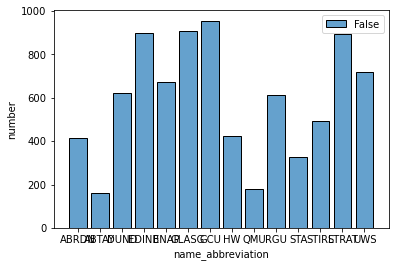

In [126]:
ax = sns.histplot(scottish_visuals_data_all_most_important, x = 'name_abbreviation', hue = (['salary_band'] == 'Less than £15,000'), weights = 'number',
                  multiple= 'stack', palette = "tab20c", shrink=0.8)
ax.set_ylabel('number')
legend = ax.get_legend()
legend.set_bbox_to_anchor((1, 1))

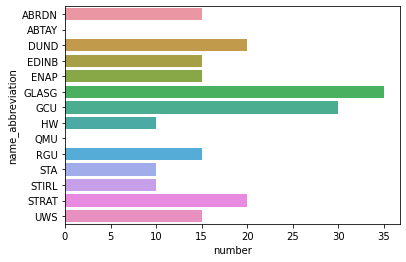

In [128]:
sns.barplot(x = "number", y = "name_abbreviation", data = scottish_visuals_data_all_most_important, estimator = np.min, ci = False)